In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn.modules.loss import _Loss
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import random_split


import torch
import torch.nn as nn
import torch.optim as optim

# Define a Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

# Define a Residual Block with Channel Attention
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.ca = ChannelAttention(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.ca(out)
        out += residual
        return out

# Define a Channel Attention Block
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, padding=0)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        out = x * self.sigmoid(avg_out)
        return out

# Define the NafNet Model
class NafNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_features=64, num_blocks=20):
        super(NafNet, self).__init__()
        self.initial_conv = ConvBlock(in_channels, num_features)
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_features) for _ in range(num_blocks)])
        self.final_conv = nn.Conv2d(num_features, out_channels, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        return self.tanh(x)






class sum_squared_error(_Loss):  # PyTorch 0.4.1
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        # return torch.sum(torch.pow(input-target,2), (0,1,2,3)).div_(2)
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)

class ImageDataset(Dataset):
    def __init__(self, image_dir):
        # Récupérer les chemins d'images
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.startswith(('clean_', 'noisy_'))]
        self.image_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))
        # Définir les transformations
        self.transform = transforms.Compose([
            #normaliser les valeurs de pixel entre 0 et 1
            transforms.ToTensor(),
            
        ])

    def __len__(self):
        return len(self.image_paths) // 2

    def __getitem__(self, idx):
        clean_image_path = self.image_paths[idx * 2]
        noisy_image_path = self.image_paths[idx * 2 + 1]
        # Ouvrir l'image et la convertir en RGB
        clean_image = Image.open(clean_image_path).convert('RGB')
        noisy_image = Image.open(noisy_image_path).convert('RGB')
        clean_image = self.transform(clean_image)
        noisy_image = self.transform(noisy_image)
        return noisy_image, clean_image
    


    

def PSNR(clean_image, noisy_image, denoised_image):
    mse_noisy = torch.mean((clean_image - noisy_image) ** 2)
    mse_denoised = torch.mean((clean_image - denoised_image) ** 2)
    psnr_noisy = 20 * torch.log10(1.0 / torch.sqrt(mse_noisy))
    psnr_denoised = 20 * torch.log10(1.0 / torch.sqrt(mse_denoised))
    return psnr_noisy.item(), psnr_denoised.item()


# Training Function
def train_dncnn(model, train_loader, val_loader, num_epochs=6, learning_rate=1e-3):
    criterion = sum_squared_error()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    train_losses = []
    val_losses = []
    train_psnrs = []
    val_psnrs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_psnr = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (noisy_images, clean_images) in progress_bar:
            noisy_images, clean_images = noisy_images.cuda(non_blocking=True), clean_images.cuda(non_blocking=True)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            outputs = torch.clamp(outputs, 0, 1)
            loss = criterion(outputs, clean_images)
            loss.backward()
            optimizer.step()

            clean_image_np = clean_images[0].cpu().numpy().transpose(1, 2, 0) 
            noisy_image_np = noisy_images[0].cpu().numpy().transpose(1, 2, 0)
            denoised_image_np = outputs[0].cpu().detach().numpy().transpose(1, 2, 0) 

            psnr_noisy, psnr_denoised = PSNR(clean_images[0], noisy_images[0], outputs[0])
            train_psnr += psnr_denoised

            running_loss += loss.item()

            

            progress_bar.set_postfix(loss=running_loss/(i+1), psnr=train_psnr/(i+1))

            if i == 0:
                plt.figure(figsize=(10, 3))
                plt.subplot(1, 3, 1)
                plt.imshow(clean_image_np.astype(np.uint8))
                plt.title('Original Image')
                plt.subplot(1, 3, 2)
                plt.imshow(noisy_image_np.astype(np.uint8))
                plt.title('Noisy Image')
                plt.subplot(1, 3, 3)
                plt.imshow(denoised_image_np.astype(np.uint8))
                plt.title('Denoised Image')
                plt.show()

                print(f"PSNR Noisy: {psnr_noisy}, PSNR Denoised: {psnr_denoised}")

        scheduler.step()
        avg_train_loss = running_loss / len(train_loader)
        avg_train_psnr = train_psnr / len(train_loader)
        train_losses.append(avg_train_loss)
        train_psnrs.append(avg_train_psnr)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Train PSNR: {avg_train_psnr}")
        
        model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        with torch.no_grad():
            for noisy_images, clean_images in val_loader:
                noisy_images, clean_images = noisy_images.cuda(non_blocking=True), clean_images.cuda(non_blocking=True)
                outputs = model(noisy_images)
                outputs = torch.clamp(outputs, 0, 1)
                loss = criterion(outputs, clean_images)
                val_loss += loss.item()

                psnr_noisy, psnr_denoised = PSNR(clean_images, noisy_images, outputs)
                val_psnr += psnr_denoised

        avg_val_loss = val_loss / len(val_loader)
        avg_val_psnr = val_psnr / len(val_loader)
        val_losses.append(avg_val_loss)
        val_psnrs.append(avg_val_psnr)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}, Validation PSNR: {avg_val_psnr}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Evolution')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_psnrs, label='Train PSNR')
    plt.plot(val_psnrs, label='Validation PSNR')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.title('PSNR Evolution')

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_psnrs, val_psnrs


# Denoising Function
def denoise_image(model, noisy_image):
    model.eval()
    with torch.no_grad():
        noisy_image = noisy_image.unsqueeze(0).cuda()
        denoised_image = model(noisy_image)
        denoised_image = torch.clamp(denoised_image, 0, 1)  # Clamp output values to range [0, 1]
        denoised_image = denoised_image.squeeze().cpu().numpy()
    return denoised_image

# Example usage
if __name__ == "__main__":
    torch.cuda.empty_cache()

    if not torch.cuda.is_available():
        raise SystemError("CUDA device is not available. Training requires a GPU.")

    print("CUDA available: ", torch.cuda.is_available())
    print("CUDA device count: ", torch.cuda.device_count())
    print("CUDA current device: ", torch.cuda.current_device())
    print("CUDA device name: ", torch.cuda.get_device_name())
    print("CUDA device capability: ", torch.cuda.get_device_capability())
    print("CUDA device memory: ", torch.cuda.get_device_properties(0).total_memory / 1e9)





    # Utilisation de la fonction pour précalculer le bruit
    
    noise_level = 25  # Niveau de bruit


    image_dir = 'C:/Users/jugou/denoiser_images'


    dataset = ImageDataset(image_dir)
    val_size = int(0.4 * len(dataset))  # 10% for validation
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    val_dataset1, val_dataset2 = random_split(val_dataset, [val_size//10, val_size - val_size//10])

    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=6, shuffle=True)

    print(f"Number of training images: {len(train_dataset)}")
    print(f"Number of validation images: {len(val_dataset)}")

    print("Number of images:", len(train_dataset))
    
    # Create the model
    model = NafNet().cuda()

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of parameters: {num_params}")
    train_dncnn(model, train_loader, val_loader)

    # Save the model
    torch.save(model.state_dict(), 'nafnet6epoch.pth')
    #Example of denoising an image
    noisy_image, clean_image = train_dataset[1]
    denoised_image = denoise_image(model, noisy_image)
    
    noisy_image_np = noisy_image.numpy().transpose(1, 2, 0) * 255.0
    clean_image_np = clean_image.numpy().transpose(1, 2, 0) * 255.0
    denoised_image_np = denoised_image.transpose(1, 2, 0) * 255.0

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(clean_image_np.astype(np.uint8))
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image_np.astype(np.uint8))
    plt.title('Noisy Image')
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image_np.astype(np.uint8))
    plt.title('Denoised Image')
    plt.show()

    # Calculate PSNR
    psnr_noisy, psnr_denoised = PSNR(clean_image, noisy_image, torch.tensor(denoised_image))
    print(f"PSNR Noisy: {psnr_noisy}, PSNR Denoised: {psnr_denoised}")

    # Calculate the pixel with the most difference
    diff = np.abs(clean_image_np - denoised_image_np)
    diff_max = np.max(np.max(diff))
    print(f"Maximum difference: {diff_max}")
    print(f"Position of maximum difference: {np.where(diff == diff_max)}")
    print(f"Value in original image: {clean_image_np[np.where(diff == diff_max)]}")
    print(f"Value in denoised image: {denoised_image_np[np.where(diff == diff_max)]}")


CUDA available:  True
CUDA device count:  1
CUDA current device:  0
CUDA device name:  NVIDIA GeForce RTX 3070 Ti
CUDA device capability:  (8, 6)
CUDA device memory:  8.589410304
Number of training images: 28455
Number of validation images: 18969
Number of images: 28455
Number of parameters: 1497491


Epoch 1/6:   0%|          | 0/4743 [00:00<?, ?it/s]c:\Users\jugou\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/6:   0%|          | 0/4743 [00:01<?, ?it/s]


KeyboardInterrupt: 

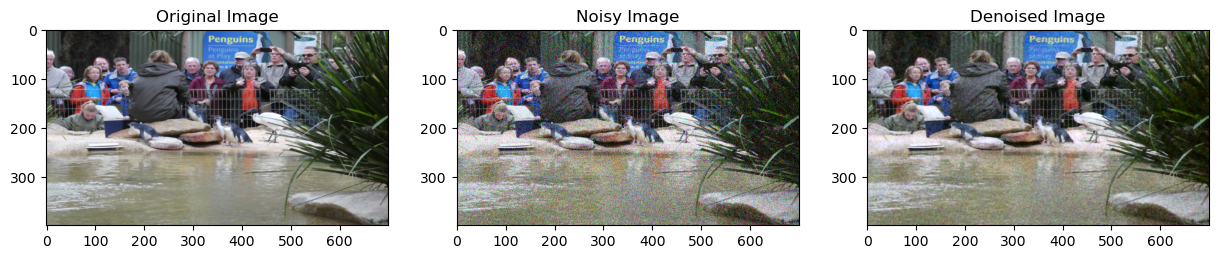

PSNR Noisy: 17.658512115478516, PSNR Denoised: 25.366981506347656
Maximum difference: 92.87277221679688
Position of maximum difference: (array([383], dtype=int64), array([97], dtype=int64), array([2], dtype=int64))
Value in original image: [101.]
Value in denoised image: [8.127224]


In [ ]:
# Example of denoising an image
noisy_image, clean_image = train_dataset[800]
denoised_image = denoise_image(model, noisy_image)

noisy_image_np = noisy_image.numpy().transpose(1, 2, 0) * 255.0
clean_image_np = clean_image.numpy().transpose(1, 2, 0) * 255.0
denoised_image_np = denoised_image.transpose(1, 2, 0) * 255.0
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(clean_image_np.astype(np.uint8))
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(noisy_image_np.astype(np.uint8))
plt.title('Noisy Image')
plt.subplot(1, 3, 3)
plt.imshow(denoised_image_np.astype(np.uint8))
plt.title('Denoised Image')
plt.show()
# Calculate PSNR
psnr_noisy, psnr_denoised = PSNR(clean_image, noisy_image, torch.tensor(denoised_image))
print(f"PSNR Noisy: {psnr_noisy}, PSNR Denoised: {psnr_denoised}")
# Calculate the pixel with the most difference
diff = np.abs(clean_image_np - denoised_image_np)
diff_max = np.max(np.max(diff))
print(f"Maximum difference: {diff_max}")
print(f"Position of maximum difference: {np.where(diff == diff_max)}")
print(f"Value in original image: {clean_image_np[np.where(diff == diff_max)]}")
print(f"Value in denoised image: {denoised_image_np[np.where(diff == diff_max)]}")
